In [ ]:
# 램오류로 인하여 결과 실행하지 못하고 제출합니다.
# 순서대로 실행 해주시길 부탁드립니다.

# **InstaCart 분석**
---

## **< 목차 >**
### 1. 프로젝트 개요
### 2. 데이터 소개 및 전처리
### 3. 데이터 EDA / RFM 분석
### 4. 가설 검증
### 5. 결론 및 마케팅 활용방안
### 6. 한계점
---

## **1. 프로젝트 개요**
- 팀원 및 소개
>- 최영은(INTP) : 발표 담당
>- 이수인(INFP) : 발표 담당
>- 이다희(INFP) : ppt 자료 담당
>- 김지영(ISFP) : 파이썬 코드 요약본 담당

- 팀 소개
>- IP Market : Instacart에 입점한 업체
>- Instacart 측으로부터 전달 받은 데이터를 분석하여 마케팅 활용 방안을 모색한다는 컨셉으로 프로젝트 진행 

- Instacart 란?
>- 주문을 하면 2시간 이내 집 앞으로 배송해주는 온라인 서비스
  
- 목적 : 주문 & 고객 데이터를 분석하여 대시보드 제작과 마케팅 활용 방안 제시
>- RFM 분석 -> 고객 세분화
>- 가설 검증

## **2. 데이터 소개**
- 데이터 : Kaggle 에서 얻은 'Instacart Market Basket Analysis' 의 총 5개의 데이터셋 사용

- RAM 오류로 각 분석 작업에서 필요한 데이터 추출, 결합하여 사용
  
- 전처리 소개
    - 총 주문자 수 : 206,209명
    - 대분류 수 : 21개
    - 소분류 수 : 134개
    - 총 상품 수 : 49,688개
    - 총 주문 건수 : 3,214,784건


In [ ]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import plotly.graph_objects as go

In [ ]:
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 모든 경고 무시
warnings.filterwarnings('ignore')

### 1) 데이터 수집

In [ ]:
# 데이터 불러오기
df_departments = pd.read_csv('departments.csv')
df_aisles = pd.read_csv('aisles.csv')
df_products = pd.read_csv('products.csv')
df_orders = pd.read_csv('orders.csv')
df_order_products = pd.read_csv('order_products__prior.csv')

- df_department : 제품 대분류
- df_aisles : 제품 소분류
- df_products : 제품
- df_orders : 주문
- df_order_products : 주문별 제품별 상품

### 2) 데이터 확인

In [ ]:
## 데이터 타입 변환 : id 컬럼들 int->string으로 변환
# departments
df_departments = df_departments.astype({
    'department_id':'str'})

# aisles
df_aisles = df_aisles.astype({
    'aisle_id':'str'})

# products
df_products = df_products.astype({
    'product_id':'str',
    'department_id':'str',
    'aisle_id':'str'})

# orders
df_orders = df_orders.astype({
    'order_id':'str',
    'user_id':'str'})

# order_products
df_order_products = df_order_products.astype({
    'order_id':'str',
    'product_id':'str'})

In [ ]:
# orders dataframe : eval_set이 prior 이외 모두 제외
df_orders = df_orders[df_orders['eval_set'] == 'prior']

# 불필요한 열(eval_set) 삭제
df_orders.drop(columns=['eval_set'], inplace = True)

# 결측치 처리
# days_since_prior_order -> NaN값 0으로 대체
df_orders['days_since_prior_order'] = df_orders['days_since_prior_order'].fillna(0)

# 주문 요일 한글로 변경
df_orders['order_dow_ori'] = df_orders['order_dow']

df_orders['order_dow'].astype(str)
dow_map = {
    0: '일요일',
    1: '월요일',
    2: '화요일',
    3: '수요일',
    4: '목요일',
    5: '금요일',
    6: '토요일'
}
df_orders['order_dow'] = df_orders['order_dow'].map(dow_map)

- 데이터 프레임 요약

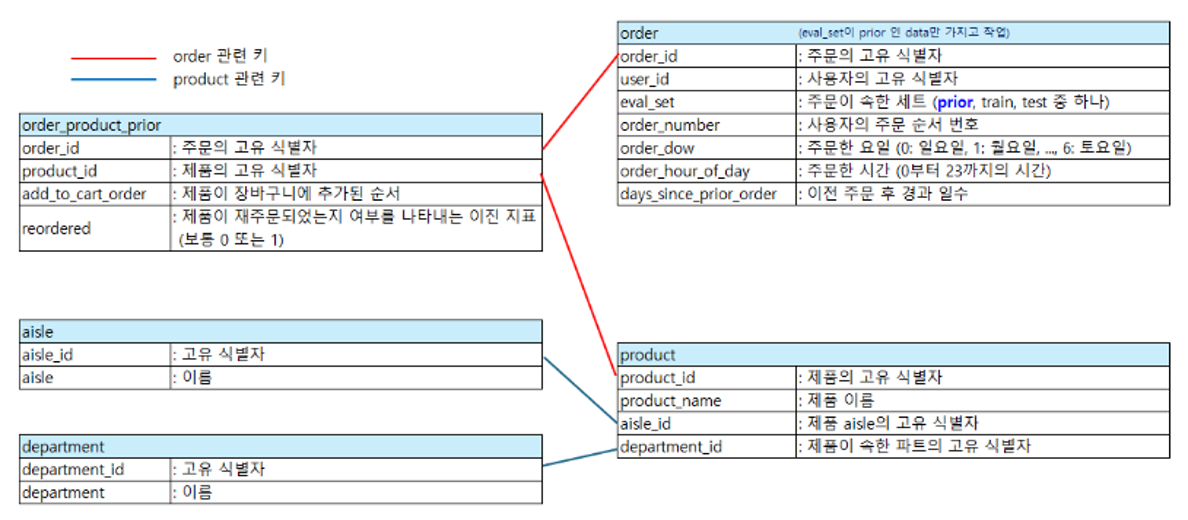

In [2]:
from IPython.display import Image
Image("data.png")

## **3. 데이터 EDA / RFM 분석**

### **3-1 데이터 EDA**
---

### 1) 요일, 시간대별 주문건 수

In [ ]:
# 시간대별 주문건 수 
def set_hour_name(h):
    txt = format(h, '02')
    return txt

order_hour_cnt = df_orders.groupby('order_hour_of_day')['order_id'].count().reset_index().sort_values('order_hour_of_day')
order_hour_cnt.columns=['order_hour_of_day', 'order_count']
order_hour_cnt['order_hour_of_day'] = order_hour_cnt['order_hour_of_day'].apply(set_hour_name)
order_hour_cnt = order_hour_cnt.astype({'order_hour_of_day': 'str'})
order_hour_cnt
# fig = px.line(order_hour_cnt, x='order_hour_of_day', y='order_count',title='시간별 주문량', height=500)
fig = px.line(order_hour_cnt,
              x='order_hour_of_day',
              y='order_count',
              title='시간대 별 주문 건수',
              height=600,
              labels={'order_hour_of_day': '시간', 'order_count': '주문 건수'})

# 시각화
fig = px.scatter(order_dow_hour_cnt,
                 x='order_hour_of_day',
                 y='order_count',
                 color='order_dow',
                 size='order_count',
                 title='주문요일과 시간에 따른 산점도',
                 labels={'order_hour_of_day': '시간', 'order_count': '주문 수', 'order_dow': '요일'},
                 height=700,
                 color_discrete_sequence=px.colors.qualitative.Vivid)
                 # color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()

- 일요일, 월요일에 주문이 가장 많았고, 목요일에 주문량이 가장 적음

### 2) 제품군 주문 건수 TOP10

In [ ]:
# 제품별 주문량 TOP!0
product_orders_cnt = df_order_products['product_id'].value_counts().sort_values(ascending=False).reset_index()
product_orders_cnt.columns = ['product_id', 'order_count']
product_orders = pd.merge(product_orders_cnt, df_products, on='product_id')
product_orders.head(10)

# 대분류별 주문량 TOP10
product_orders_depart = product_orders.groupby('department_id')['order_count'].sum().sort_values(ascending=False)
product_orders_depart = pd.merge(product_orders_depart, df_departments, on='department_id')
product_orders_depart.head(10)

# 소분류별 주문량 TOP10
product_orders_aisles = product_orders.groupby('aisle_id')['order_count'].sum().sort_values(ascending=False)
product_orders_aisles = pd.merge(product_orders_aisles, df_aisles, on='aisle_id')
data = product_orders_aisles.head(10)

- produce 카테고리의 fresh fruits 주문 건수가 많음

### 3) 카테고리별 제품별 인기상품 키워드

In [ ]:
# 카테고리별 워드클라우드
from wordcloud import WordCloud

# 데이터 결합
df = pd.merge(df_order_products, df_products, on='product_id', how='left')
df = pd.merge(df, df_aisles, on='aisle_id', how='left') 

# 소분류별 빈도수 계산
aisle_name_freq = df['aisle'].value_counts()

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(aisle_name_freq)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('aisle Word Cloud')
plt.show()

In [ ]:
# 제품명 워드클라우드
# 제품명 빈도수 계산
product_name_freq = df['product_name'].value_counts()

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(product_name_freq)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('product name Word Cloud')
plt.show()

### 4) 제품별 재주문율과 재주문 기간

In [ ]:
# 전체 주문 중 재주문 비율
reorder_ratio = df_order_products['reordered'].sum() / df_order_products.shape[0]
nonreorder_ration = 1-reorder_ratio

data = [['reorder', 59], ['nonreorder', 41]]
df = pd.DataFrame(data, columns=['재주문 여부', '비율'])

data=[59, 41]
plt.title('전체 주문 비율')
label=['재주문', '첫주문']
colors = ['salmon', 'lightgray']
plt.pie(data, labels=label, autopct='%.f%%', explode=(0.05, 0), shadow=True, colors=colors)
plt.legend()
plt.show()

In [ ]:
# 재주문 기간
df_orders['days_since_prior_order'] = df_orders['days_since_prior_order'].astype(int)

plt.figure(figsize=(12,8))
sns.countplot(data=df_orders, x='days_since_prior_order', color='#4C6EF0')
plt.xlabel('이전 주문 후 지난 일수')
plt.ylabel('주문량')
plt.title('재주문 기간', fontsize=14)
plt.show()

- 전체 주문 중 59%가 재주문

- 7일만에 재주문이 가장 많음

### 5) 고객별 주문건수에 따른 재주문율

In [ ]:
# 고객별 총 주문횟수
user_orders_cnt = df_orders['user_id'].value_counts().reset_index()
user_orders_cnt.columns = ['user_id', 'order_count']

# 재주문율계산
# 주문별 평균
user_reorders_mean = df_order_products.groupby('order_id')['reordered'].mean().reset_index()
df_user_reorder_rate = pd.merge(df_orders, user_reorders_mean, on='order_id')
# 사용자별 평균
df_user_reorder_rate = df_user_reorder_rate.groupby('user_id')['reordered'].mean().reset_index()
df_user_reorder_rate = pd.merge(user_orders_cnt, df_user_reorder_rate, on='user_id')

# 주문 건수와 재주문율 상관관계
r_reorder_rate[['order_count', 'reordered']].corr()

# 시각화 (산점도와 추세선)
fig = px.scatter(df_user_reorder_rate,
                 x='order_count',
                 y='reordered',
                 trendline='ols',
                 height=600,
                 labels={'order_count': '주문 건수', 'reordered': '재주문율'},
                 title='주문 건수와 재주문율의 산점도')
trendline = fig.data[1]
trendline.line.color = 'red'
fig.show()

- 상관계수 : 0.61 (양의 상관관계)
- 주문 건수가 많은 고객일수록 재주문율 또한 높음

### 6) 장바구니 추가 순서에 따른 인기제품과 비인기제품

In [ ]:
# 데이터 결합 & 이름 변경
# df_order_products와 df_products 결합 (공통 식별자 -> product_id : 제품의 고유 식별자)
df1 = pd.merge(df_order_products, df_products, on='product_id', how='left')

# df1와 df_orders 결합 (공통 식별자 -> order_id )
df2 = pd.merge(df1, df_orders, on='order_id', how='left')
df = df2

# 열 이름 변경
df.rename(columns={
    'add_to_cart_order': '장바구니_추가_순서',
    'reordered': '재주문_여부',
    'product_name': '제품_이름',
    'order_number': '주문_번호',
    'order_dow': '주문_요일',
    'order_hour_of_day': '주문_시간',
    'days_since_prior_order': '이전_주문_후_지난_일수'
}, inplace=True)

# 열 순서 변경
new_order = ['user_id', 'product_id', 'aisle_id',  'order_id', 'department_id', '제품_이름', '주문_번호', '주문_요일', '주문_시간', '장바구니_추가_순서', '재주문_여부','이전_주문_후_지난_일수']
df = df[new_order]

- 계란, 우유 등 신선식품은 인기제품 / 아기용품, 인스턴트는 비인기제품

In [ ]:
# 필요한 열만 추출
df_orders_prior = df_orders[['order_id', 'user_id']]

# 필요한 데이터 추출 & 결합
df_order_products_reduced = df_order_products[['order_id', 'product_id', 'add_to_cart_order', 'reordered']]
df_products_reduced = df_products[['product_id', 'aisle_id']]
df_aisles_reduced = df_aisles[['aisle_id', 'aisle']]

df1 = pd.merge(df_order_products_reduced, df_products_reduced, on='product_id', how='left')
df2 = pd.merge(df1, df_orders_prior, on='order_id', how='left')
df_final = pd.merge(df2, df_aisles_reduced, on='aisle_id', how='left')

# 열 이름 변경
df_final.rename(columns={
    'add_to_cart_order': '장바구니_추가_순서',
    'reordered': '재주문_여부',
    'aisle': '카테고리'
}, inplace=True)
df_final = df_final[['user_id', 'product_id', 'aisle_id', 'order_id', '카테고리', '장바구니_추가_순서', '재주문_여부']]

# 카테고리별 장바구니 추가 순서 분석 (소수점 두 번째 자리까지 표시)
df_카테고리별_장바구니_추가순서 = df_final.groupby('카테고리')['장바구니_추가_순서'].mean().reset_index()
df_카테고리별_장바구니_추가순서 = df_카테고리별_장바구니_추가순서.sort_values(by='장바구니_추가_순서')
df_카테고리별_장바구니_추가순서['장바구니_추가_순서'] = df_카테고리별_장바구니_추가순서['장바구니_추가_순서'].round(2)

## 인기제품 TOP20
카테고리_상위20 = df_카테고리별_장바구니_추가순서.head(20)
# 시각화
plt.figure(figsize=(10, 8))
plt.barh(카테고리_상위20['카테고리'], 카테고리_상위20['장바구니_추가_순서'], color='skyblue')
plt.xlabel('장바구니 추가 순서')
plt.ylabel('카테고리')
plt.title('카테고리별 장바구니 추가 순서 - 상위 20개')
plt.gca().invert_yaxis()  # 카테고리 이름이 위에서 아래로 나오도록
plt.show()

## 비인기제품 TOP20
카테고리_하위20 = df_카테고리별_장바구니_추가순서.tail(20)
# 시각화
plt.figure(figsize=(10, 8))
plt.barh(카테고리_하위20['카테고리'], 카테고리_하위20['장바구니_추가_순서'], color='salmon')
plt.xlabel('장바구니 추가 순서')
plt.ylabel('카테고리')
plt.title('카테고리별 장바구니 추가 순서 - 하위 20개')
plt.gca().invert_yaxis()  # 카테고리 이름이 위에서 아래로 나오도록
plt.show()

### 7) 제품별 장바구니 추가 순위

In [ ]:
# 필요한 열 추출
df_장바구니 = df[['order_id','제품_이름', '장바구니_추가_순서','재주문_여부']]

# 각 제품의 누적 주문 횟수 추가
주문_횟수_카운트= df.groupby('제품_이름')['order_id'].nunique()
df_장바구니['누적_주문_횟수'] = df_장바구니['제품_이름'].map(주문_횟수_카운트)

# 각 제품의 평균 장바구니 추가 순서 계산 (소수점 두 번째 자리까지 표시)
df_장바구니['장바구니_추가순서_평균'] = df_장바구니.groupby('제품_이름')['장바구니_추가_순서'].transform('mean')
df_장바구니['장바구니_추가순서_평균'] = df_장바구니['장바구니_추가순서_평균'].round(2)

# 누적 주문 횟수를 기준으로 내림차순 (장바구니 추가 순서의 평균이 동일할 경우)
df_장바구니_순서 = df_장바구니.drop_duplicates(subset=['제품_이름']).sort_values(by=['장바구니_추가순서_평균', '누적_주문_횟수'], ascending=[True, False])

# 누적 주문 횟수가 10 이상 추출
df_장바구니_순서_필터링 = df_장바구니_순서[df_장바구니_순서['누적_주문_횟수'] >= 10]

- 주문 건수가 적은 제품일수록 순위가 높을 수 있으므로 누적 주문 건수 >= 10 제품 추출

### 8) 장바구니에 빠르게 담기는 제품 TOP20

In [ ]:
# 제품 TOP20
장바구니_추가순서_Top20 = df_장바구니_순서_필터링.head(20)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    x='장바구니_추가순서_평균',
    y='제품_이름',
    data=장바구니_추가순서_Top20,
    palette='viridis'
)
plt.title('어떤제품을 장바구니에 우선적으로 추가할까? Top20')
plt.xlabel('장바구니 추가순서(평균)')
plt.ylabel('제품')
plt.show()

- 누적 주문 횟수 10회 이상인 제품 중 요거트 망고맛, 유아용 분유, 삼페인 등이 상위권에 위치

### 9) 재주문율 높은 제품과 낮은 제품 TOP20

In [ ]:
df_재주문 = df_장바구니.sort_values(by=['장바구니_추가순서_평균', '누적_주문_횟수'], ascending=[True, False])

# 제품별로 재주문율 계산
df_재주문율 = df_재주문.groupby('제품_이름').agg({
    '재주문_여부': 'mean',
    '장바구니_추가순서_평균': 'first',  # 평균값은 동일 -> 첫 번째 값 사용
    '누적_주문_횟수': 'first'
}).reset_index()

# 재주문 여부가 0인 제품 제외
df_재주문율 = df_재주문율[df_재주문율['재주문_여부'] > 0]

# 재주문 여부 기준 내림차순 정렬
df_재주문율 = df_재주문율.sort_values(by='재주문_여부', ascending=False)

# 소수점 두 번째 자리까지 표시
df_재주문율['재주문_여부'] = df_재주문율['재주문_여부'].round(2)
df_재주문율['장바구니_추가순서_평균'] = df_재주문율['장바구니_추가순서_평균'].round(2)


## 재주문율 높은 제품 TOP20
top_20 = df_재주문율.head(20)
# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_20['제품_이름'], top_20['재주문_여부'], color='skyblue')
plt.xlabel('재주문율')
plt.ylabel('제품 이름')
plt.title('재주문율 제품 상위20')
plt.gca().invert_yaxis()  # y축 역순으로 설정하여 상위부터 아래로 표시
plt.show()

## 재주문율 낮은 제품 TOP20
bottom_20 = df_재주문율.tail(20)
# 시각화
plt.figure(figsize=(10, 6))
plt.barh(bottom_20['제품_이름'], bottom_20['재주문_여부'], color='salmon')
plt.xlabel('재주문율')
plt.ylabel('제품 이름')
plt.title('재주문율 제품 하위20')
plt.gca().invert_yaxis()  # y축 역순으로 설정하여 상위부터 아래로 표시
plt.show()

- 재주문율 높은 상품 : 랩, 여성용품, 유아용품, 에너지 드링크 등
- 재주문율 낮은 상품 : 유기농 향신료, 접착제, 드라이샴푸 등

### **3-2 RFM 분석**
---
- 분석 목적 <br>
(1) 고객을 세분화하고 이들의 주문 패턴 파악 <br>
(2) 최우수 고객을 대상으로 한 제품 연관분석 <br>
(3) 이탈(위험)고객 대상으로 한 제품 선호도 분석 <br>

- 각각 3개 등급으로 나누어 전체 RFM 점수 산출

-  **Recency** : 사용자별 이전 주문일 이후 경과일수 (order.csv의 days_since_prior_order 컬럼의 값)

-  **Frequency** : 사용자별 주문개수 (user_orders_cnt의 data)

-   **Monetary** : 사용자별 주문한 상품 개수 > 상품 금액이 없는 대신 상품 수량으로 대체

In [ ]:
# Recency (평균해서 올림)
df_rfm = df_orders.groupby(['user_id'])['days_since_prior_order'].mean().reset_index() # 사용자별 주문경과일수의 평균
df_rfm.columns = ['user_id', 'recency']
df_rfm['recency'] = df_rfm['recency'].apply(math.ceil)

# Frequency
df_rfm = pd.merge(df_rfm, user_orders_cnt, on='user_id')
df_rfm.columns = ['user_id', 'recency', 'frequency']
df_rfm 

# Monetary
df_order_procuts_cnt = df_order_products.groupby('order_id')['product_id'].size().reset_index()
df_order_procuts_cnt.columns = ['order_id', 'monetary']
df_mt = pd.merge(df_orders, df_order_procuts_cnt, on='order_id')
df_mt = df_mt.groupby('user_id')['monetary'].sum().reset_index()
df_rfm = pd.merge(df_rfm,df_mt, on='user_id')

# 각 지표에 대한 점수 부여 (3등급씩)
df_rfm['r_score'] = pd.qcut(df_rfm['recency'], 3, labels=[3, 2, 1])
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), 3, labels=[1, 2, 3])
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], 3, labels=[1, 2, 3])

# 최종 RFM 점수
df_rfm['RFM_Score'] = df_rfm['r_score'].astype(str) + df_rfm['f_score'].astype(str) + df_rfm['m_score'].astype(str)

# 고객 세분화
def rfm_segment(score):
    segment = ''
    if score == '333':
        segment='최우수'
    elif score == '111':
        segment='이탈고객'
    elif score == '222':
        segment='일반'
    elif score in ['332','331','233','133','323','313']:
        segment='우수'
    elif score in ['321','312','322']:
        segment='일반_최근고객'
    elif score in ['232','132','231']:
        segment='일반_자주주문'
    elif score in ['223','123','213']:
        segment='일반_대량구매'
    else:
        segment='구매유도(이탈위험)'

    return segment

# 고객 등급
def rfm_grade(score):
    if score == '333':
        grade= 1
    elif score == '111':
        grade= 5
    elif score == '222':
        grade= 3
    elif score in ['332','331','233','133','323','313']:
        grade= 2
    elif score in ['321','312','322']:
        grade= 3
    elif score in ['232','132','231']:
        grade= 3
    elif score in ['223','123','213']:
        grade= 3
    else:
        grade= 4
        
    return grade

df_rfm['RFM_grade'] = df_rfm['RFM_Score'].apply(rfm_grade)
df_rfm['RFM_segment'] = df_rfm['RFM_Score'].apply(rfm_segment)

# 각 세그먼트별 고객 수
df_segment = df_rfm.groupby(['RFM_segment','RFM_grade'])['user_id'].count().reset_index().sort_values('RFM_grade')
df_segment.columns = ['segment', 'grade', 'count']
df_segment

# 시각화
fig = px.bar(df_segment, x='segment', y='count', title='고객 RFM 분석', height=600)
fig.show()

fig = px.treemap(data_frame=df_segment,
                 path=['segment'],
                 values='count',
                 title='고객 RFM 분석',
                 height=700,
                 color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()

In [ ]:
# 세그먼트 Pie차트 시각화
fig = go.Figure(data=[go.Pie(labels=df_segment['segment'],
                             values=df_segment['count'],
                             sort=False,
                             marker=dict(colors=px.colors.qualitative.Pastel))
                     ]
               )
fig.update_layout(title='고객 세분화', width=800, height=600)
fig.show()

- 최우수 우수 고객은 전체 30%, 구매유도/이탈고객은 전체 45% 차지

(1) 고객의 주문 패턴 파악
- 요일별 세그먼트 고객 분포

In [ ]:
# 고객세분화 - 주문요일과 시간에 따른 산점도
df_order_user_seg = df_orders.groupby(['user_id', 'order_dow_ori', 'order_hour_of_day'])['order_id'].count().reset_index(name='order_count')
df_order_user_seg = pd.merge(df_order_user_seg, df_rfm, on='user_id').sort_values(['order_dow_ori','order_hour_of_day', 'RFM_grade','RFM_segment'])
df_order_user_seg['order_hour_of_day'] = df_order_user_seg['order_hour_of_day'].apply(set_hour_name)
df_order_user_seg

In [ ]:
# 요일별 등급
order_user_dow_cnt = df_order_user_seg.groupby(['order_dow_ori', 'RFM_grade', 'RFM_segment'])['order_count'].sum()\
                                     .reset_index().sort_values(['order_dow_ori','RFM_grade','RFM_segment'])
order_user_dow_cnt['order_dow'] = order_user_dow_cnt['order_dow_ori'].map(dow_map)

# 요일별 비율
total_order_per_dow = order_user_dow_cnt.groupby('order_dow')['order_count'].sum().reset_index(name='total_dow_order_count')
order_user_dow_cnt = pd.merge(order_user_dow_cnt, total_order_per_dow, on='order_dow')
order_user_dow_cnt['order_ratio'] = (order_user_dow_cnt['order_count'] / order_user_dow_cnt['total_dow_order_count'] * 100)


In [ ]:
# 고객 주문 건수에 따른 요일별 분포 시각화
fig = px.bar(order_user_dow_cnt,
                 x='order_dow',
                 y='order_count',
                 color='RFM_segment',
                 title='요일별 고객 주문 건수',
                 labels={'order_dow': '요일', 'order_count': '주문 수'},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 height=700)
fig.show()

# 고객 주문 건수 비율에 따른 요일별 분포 시각화
fig = px.bar(order_user_dow_cnt,
                 x='order_dow',
                 y='order_ratio',
                 color='RFM_segment',
                 title='요일별 고객 주문 건수 비율',
                 labels={'order_dow': '요일', 'order_count': '주문 수'},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 height=700)
fig.show()

- 주문 건수와 주문율을 비교해봤을 때 건수와 비율은 그다지 차이가 없다는 것을 확인 <br>
 -> 고객 세그먼트별로 큰 차이가 없음

- 시간대별 세그먼트 고객 분포

In [ ]:
# 시간대별 등급
order_user_hour_cnt = df_order_user_seg.groupby(['order_hour_of_day', 'RFM_grade', 'RFM_segment'])['order_count'].sum()\
                                          .reset_index().sort_values(['order_hour_of_day','RFM_grade','RFM_segment'])
# 시간대별 비율
total_order_per_hour = order_user_hour_cnt.groupby('order_hour_of_day')['order_count'].sum().reset_index(name='total_hour_order_count')
order_user_hour_cnt = pd.merge(order_user_hour_cnt, total_order_per_hour, on='order_hour_of_day')
order_user_hour_cnt['order_ratio'] = (order_user_hour_cnt['order_count'] / order_user_hour_cnt['total_hour_order_count'] * 100)

In [ ]:
# 고객 주문 건수에 따른 시간별 분포 시각화
fig = px.bar(order_user_hour_cnt,
                 x='order_hour_of_day',
                 y='order_count',
                 color='RFM_segment',
                 title='시간대 별 고객 주문 건수',
                 labels={'order_hour_of_day': '시간', 'order_count': '주문 수'},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 height=700)
fig.show()

In [ ]:
# 고객 주문 건수 비율에 따른 시간별 분포 시각화
fig = px.bar(order_user_hour_cnt,
                 x='order_hour_of_day',
                 y='order_ratio',
                 color='RFM_segment',
                 title='시간대 별 고객 주문 건수 비율',
                 labels={'order_hour_of_day': '시간', 'order_count': '주문 수'},
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 height=700)
fig.show()

- 주문 건수와 주문율을 비교해봤을 때 건수와 비율은 그다지 차이가 없다는 것을 확인 <br>
 -> 요일별 데이터 분석 결과와 유사

- 고객 등급에 상관없이 일요일, 월요일 그리고 오전 시간대에 주문이 많이 발생

- 전체 주문 건수 중 최우수/우수 고객이 70%정도 차지하는 것으로 보아 그들의 구매력이 상당하다는 것을 알 수 있음 <br>
   -> 구매유도/이탈 고객은 고객 수는 많지만 실제 주문은 적어 구매력은 낮은 것으로 알 수 있음

(2) 최우수 고객의 주문 상품 연관 분석 (파일 따로 첨부)

(3) 이탈(위험)고객의 제품 선호도 분석 

In [ ]:
## 이탈고객의 인기 제품 TOP20
# 이탈 고객 세그먼트 추출
df_churn_customers = df_rfm[df_rfm['RFM_segment'] == '이탈고객']
df_churn_customers.head()

# 이탈 고객 수 및 비율 ( 이탈 고객 수: 26532 이탈 고객 비율: 12.87% )
total_customers = df_rfm.shape[0]
churn_customers_count = df_churn_customers.shape[0]
churn_customers_percentage = (churn_customers_count / total_customers) * 100

# 이탈 고객의 주문 데이터 추출
churn_orders = df_orders[df_orders['user_id'].isin(df_churn_customers['user_id'])]

# 이탈 고객의 주문 제품 데이터 추출
churn_order_products = df_order_products[df_order_products['order_id'].isin(churn_orders['order_id'])]

# 이탈 고객의 제품 선호도 분석
churn_product_counts = churn_order_products['product_id'].value_counts().reset_index()
churn_product_counts.columns = ['product_id', 'count']

# 제품 이름과 결합
churn_product_counts = pd.merge(churn_product_counts, df_products[['product_id', 'product_name']], on='product_id')

# 시각화
fig = px.bar(churn_product_counts.head(20), x='product_name', y='count', title='이탈 고객의 인기 제품 Top 20', labels={'product_name': '제품 이름', 'count': '구매 횟수'}, height=600, color='product_name', color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

In [ ]:
## 이탈위험고객의 인기 제품 TOP20
# 이탈위험 세그먼트 추출 : df_rfm
df_risk_churn_customers = df_rfm[df_rfm['RFM_segment'] == '구매유도(이탈위험)']
df_risk_churn_customers.head()

# 이탈위험 고객 수 및 비율 / 고객 수: 64411 이탈위험 고객 비율: 31.24%
total_customers = df_rfm.shape[0]
risk_churn_customers_count = df_risk_churn_customers.shape[0]
risk_churn_customers_percentage = (risk_churn_customers_count / total_customers) * 100

# 이탈위험 고객의 주문 데이터 추출
risk_churn_orders = df_orders[df_orders['user_id'].isin(df_risk_churn_customers['user_id'])]

# 이탈위험 고객의 주문 제품 데이터 추출
risk_churn_order_products = df_order_products[df_order_products['order_id'].isin(risk_churn_orders['order_id'])]

# 이탈위험 고객의 제품 선호도 분석
risk_churn_product_counts = risk_churn_order_products['product_id'].value_counts().reset_index()
risk_churn_product_counts.columns = ['product_id', 'count']

# 제품 이름과 결합
risk_churn_product_counts = pd.merge(risk_churn_product_counts, df_products[['product_id', 'product_name']], on='product_id')

# 시각화
fig = px.bar(risk_churn_product_counts.head(20), 
             x='product_name', 
             y='count', 
             title='이탈위험 고객의 인기 제품 Top 20', 
             labels={'product_name': '제품 이름', 'count': '구매 횟수'}, 
             height=600,
             color='count',
             color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

- 바나나, 레몬 등 신선제품이 인기

- 고객 등급과 상관없이 구매하는 상품 선호도는 거의 비슷함 <br>
 -> 제품보다는 다른 부분에서 프로모션을 진행하는 것이 더 효과적일 것이라 판단

## **4. 가설 검증**

### 1) 요일별 주문량의 차이는 크지 않을 것이다.
---

In [ ]:
# 요일별 주문량 
order_dow_cnt = df_orders.groupby('order_dow_ori')['order_id'].count().reset_index().sort_values('order_dow_ori')
order_dow_cnt.columns=['order_dow', 'order_count']

# 주문요일 한글로 변경
order_dow_cnt['order_dow'].astype(str)
order_dow_cnt['order_dow'] = order_dow_cnt['order_dow'].map(dow_map)

# 시각화
fig = px.line(order_dow_cnt,
              x='order_dow',
              y='order_count',
              labels={'order_count': '주문 건수', 'order_dow': '요일'},
              title='요일별 주문량',
              height=500
              )
fig.show()

- 일요일, 월요일에 주문 건수가 많고 목요일이 가장 적음

### 2) 금요일의 경우 알코올 주문량이 많을 것이다.
---

In [ ]:
# alcohol 대분류인 주문만 추출
df_depart_alcohol = df_departments[df_departments['department_id'] == '5'] # department_id : 5 (alcohol)
df_prod_alcohol = pd.merge(df_products, df_depart_alcohol, on = 'department_id', how='inner')
df_ord_alcohol = pd.merge(df_order_products, df_prod_alcohol, on = 'product_id', how='inner')
df_ord_alcohol = pd.merge(df_orders, df_ord_alcohol, on = 'order_id', how='inner')
df_ord_alcohol = df_ord_alcohol.groupby('order_dow_ori')['order_id'].count().reset_index(name='order_count').sort_values('order_dow_ori')
df_ord_alcohol.columns=['order_dow', 'order_count']

# 주문요일 한글로 변경
df_ord_alcohol['order_dow'] = df_ord_alcohol['order_dow'].map(dow_map)

# 시각화
fig = px.line(df_ord_alcohol,
              x='order_dow',
              y='order_count',
              title='요일별 Alcohol 주문 수', height=500,
              labels={'order_dow': '요일', 'order_count': 'Alcohol 주문 수'})
fig.show()

- 금요일의 주류 판매 건수 대폭 증가

### 3) 자주 판매되는 상품은 주로 오전 시간대일 것이다.
---

In [ ]:
# 필요한 데이터 추출 & 결합
need_col = ['order_id', 'order_dow', 'order_hour_of_day']
orders_need = df_orders[need_col]

need_col1 = ['order_id', 'product_id']
order_products_need = df_order_products[need_col1]

df1 = pd.merge(df_products, order_products_need, on='product_id', how='left')
df_total = pd.merge(df1, orders_need, on='order_id')

# 데이터 순서 정렬, 'order_id' 타입 정수로 변환
new_order = ['order_id', 'product_id', 'product_name', 'order_dow', 'order_hour_of_day', 'department_id', 'aisle_id']
df_total = df_total[new_order]

In [ ]:
# 시간대별로 나누기
def time_(hour):
    if 0 <= hour < 6:
        return '0시 ~ 6시'
    elif 6 <= hour < 12:
        return '6시 ~ 12시'
    elif 12 <= hour < 17:
        return '12시 ~ 17시'        
    else:
        return '17시 ~ 23시'
        
# 시간대 컬럼 추가
df_total2 = df_total.copy()
df_total2['time_period'] = df_total['order_hour_of_day'].apply(time_)

# 시간대별 상품 추출
top_df_total2 = df_total2.groupby(['time_period', 'product_name']).size().reset_index(name='count')
top_df_total2 = top_df_total2.sort_values(['time_period', 'count'], ascending=[True, False])

# 시간대별 가장 잘 팔리는 상품 top10 추출
top10_df_total2 = top_df_total2.groupby('time_period').head(10)

# 시각화
plt.rc('font', family='Malgun Gothic')

plt.figure(figsize=(16,12))

time_period = ['0시 ~ 6시', '6시 ~ 12시', '12시 ~ 17시', '17시 ~ 23시']
for i in range(len(time_period)):
    plt.subplot(2, 2, i + 1)
    period = time_period[i]
    data = top10_df_total2[top10_df_total2['time_period'] == period]
    sns.barplot(x='product_name', y='count', data=data, palette='tab20c')
    plt.title(f'{period} 상위 10개 상품', fontsize='15', fontweight='bold')
    plt.xlabel('상품명')
    plt.ylabel('주문량')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- 시간대마다 주문량은 차이가 있으나 자주 판매되는 상품은 시간대별로 동일함

### 4) 고객별 총 주문제품의 개수가 적을수록 구매주기가 평균적으로 짧을 것이다.
---

In [ ]:
# 고객별 주문 상품의 갯수 계산
customer_order = df_order_products.groupby('order_id').size().reset_index(name='product_count')
df_orders1 = df_orders.merge(customer_order, on='order_id', how='left')
df_orders1.sort_values(by='product_count')

# # 각 고객별 총 주문 상품 갯수 계산
customer_total_ordered_products = df_orders1.groupby('user_id')['product_count'].sum().reset_index(name='total_product_count')

# 고객별 평균 주문 주기 계산
orders = df_orders.sort_values(by=['user_id', 'order_number'])
customer_order_period = orders.groupby('user_id')['days_since_prior_order'].mean().reset_index(name='order_avg')

# 고객별 총 주문 상품 갯수와 평균 주문 주기 결합
customer_product_period = customer_total_ordered_products.merge(customer_order_period, on='user_id', how='left')

# 상관계수 계산
customer_product_period[['total_product_count', 'order_avg']].corr()

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_product_period, x='total_product_count', y='order_avg', alpha=0.5)
sns.regplot(data=customer_product_period, x='total_product_count', y='order_avg', scatter=False, color='red')
plt.title('총 주문상품 갯수와 평균적인 주문주기 상관관계')
plt.xlabel('총 주문상품 갯수')
plt.ylabel('주문주기 평균')
plt.ylim(-10, 30)
plt.show()

- 상관계수 : -0.388853 (약한 음의 상관관계)
- 총 주문제품의 개수가 많은 고객일수록 평균적인 구매주기가 조금은 짧아짐

### 5) 이탈율이 높은 고객의 대부분은 비인기제품을 사는 경우일 것이다.
---

(1) RFM (위의 RFM 과정과 동일)

In [ ]:
# 각 세그먼트별 고객 수 계산
df_segment = df_rfm['RFM_segment'].value_counts().reset_index()
df_segment.columns = ['segment', 'count']

# 세그먼트별 고객 비율 계산
df_segment['percentage'] = (df_segment['count'] / df_rfm.shape[0]) * 100

(2) 비인기 소분류 제품 하위 30% 추출

In [ ]:
# 상품별 주문량
product_orders_cnt = df_order_products['product_id'].value_counts().sort_values(ascending=False).reset_index()
product_orders_cnt.columns = ['product_id', 'order_count']
product_orders = pd.merge(product_orders_cnt, df_products, on='product_id')

# 하위 30% 주문 횟수 계산
lower_30th_percentile = product_orders['order_count'].quantile(0.3)

# 하위 30%에 해당하는 비인기 상품 추출
unpopular_products = product_orders[product_orders['order_count'] <= lower_30th_percentile]

# unpopular_products에 aisle 정보 추가
unpopular_products = pd.merge(unpopular_products, df_aisles[['aisle_id', 'aisle']], on='aisle_id', how='left')

# 비인기 상품의 개수가 많은 순으로 상위 20개 Aisle 추출
top_20_unpopular_aisles = unpopular_products['aisle'].value_counts().head(20)

# 색상 설정을 위한 컬러맵 생성
colors = plt.cm.tab20(np.linspace(0, 1, 20))

# 시각화
plt.figure(figsize=(12, 8))
top_20_unpopular_aisles.sort_values().plot(kind='barh', color=colors)
plt.title('Top 20 Unpopular Aisles')
plt.xlabel('Number of Unpopular Products')
plt.ylabel('Aisle')
plt.gca().invert_yaxis()  # 상위에서부터 내림차순으로 표시
plt.show()

- 헤어/바디케어 제품과 반려동물 사료, 디저트

(3) 고객별 제품 샘플 데이터 (랜덤데이터 30%)

In [ ]:
# 원본 데이터프레임에서 랜덤하게 30% 샘플 추출
df_orders_sample = df_orders.sample(frac=0.3, random_state=1)
df_order_products_sample = df_order_products.sample(frac=0.3, random_state=1)
df_products_sample = df_products.sample(frac=0.3, random_state=1)

# 주문 데이터프레임과 RFM 데이터프레임 결합
order_rfm_sample = pd.merge(df_orders_sample, df_rfm, on='user_id', how='left')

# order_rfm_sample와 df_order_products_sample 결합하여 제품 아이디 추가
order_rfm_sample = pd.merge(order_rfm_sample, df_order_products_sample, on='order_id', how='left')

# df_products_sample와 결합하여 제품 이름 추가
order_rfm_sample = pd.merge(order_rfm_sample, df_products_sample[['product_id', 'product_name']], on='product_id', how='left')

# 필요한 열만 추출
order_rfm_sample = order_rfm_sample[['user_id','RFM_segment', 'RFM_Score', 'product_name', 'recency', 'frequency', 'monetary']]

#결측치 확인: 3054215 rows 데이터 중 product_name 제품 2233175 
print(order_rfm_sample.isnull().sum())

#결측치 제거 : 821040 rows × 7 columns 데이터
order_rfm_sample = order_rfm_sample.dropna()
order_rfm_sample

- 821,880의 rows 데이터를 기반으로 분석 진행

(4) 이탈고객과 이탈위험고객

In [ ]:
# 각 세그먼트별 고객 수 계산
df_segment = df_rfm['RFM_segment'].value_counts().reset_index()
df_segment.columns = ['segment', 'count']
print(df_segment)

# 세그먼트별 고객 비율 계산
df_segment['percentage'] = (df_segment['count'] / df_rfm.shape[0]) * 10
# 세그먼트별 고객 비율 파이 차트 시각화
fig = px.pie(df_segment, names='segment', values='percentage', title='고객 RFM 세그먼트 비율',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

In [ ]:
# 세그먼트별 고객 비율 막대 차트 시각화
fig = px.bar(df_segment, x='segment', y='percentage', title='고객 RFM 세그먼트 비율',
             color='segment', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis_title='Segment', yaxis_title='Percentage')
fig.show()

- 세그먼트 기준 3~5점에 속하는 고객을 이탈율이 높다고 판단

(5) 이탈고객과 비인기 제품의 상관분석

In [ ]:
# 비인기 제품 리스트
unpopular_product_names = unpopular_products['product_name'].tolist()

# 샘플 데이터에서 비인기 제품 포함한 구매 수 계산
unpopular_purchase_counts_sample = order_rfm_sample[order_rfm_sample['product_name'].isin(unpopular_product_names)].groupby('RFM_segment')['product_name'].count().reset_index()
unpopular_purchase_counts_sample.columns = ['RFM_segment', 'unpopular_purchase_count']

# 각 세그먼트별 전체 구매 수 계산
total_purchase_counts_sample = order_rfm_sample.groupby('RFM_segment')['product_name'].count().reset_index()
total_purchase_counts_sample.columns = ['RFM_segment', 'total_purchase_count']

# 비인기 제품 구매 비율 계산
purchase_counts_sample = pd.merge(unpopular_purchase_counts_sample, total_purchase_counts_sample, on='RFM_segment')
purchase_counts_sample['unpopular_purchase_rate'] = purchase_counts_sample['unpopular_purchase_count'] / purchase_counts_sample['total_purchase_count']

# 시각화
fig = px.histogram(
    purchase_counts_sample, 
    x='RFM_segment', 
    y='unpopular_purchase_rate', 
    title='RFM 세그먼트별 비인기 제품 구매 비율', 
    labels={'RFM_segment': 'RFM 세그먼트', 'unpopular_purchase_rate': '비인기 제품 구매 비율'},
    color='RFM_segment',
    color_discrete_sequence=px.colors.qualitative.Set3
)
ig.update_layout(height=600)
fig.show()

In [ ]:
## RFM 세그먼트별 비인기 제품 구매 횟수
# 비인기 제품 구매 횟수 기준으로 오름차순 정렬
unpopular_purchase_counts_sample = unpopular_purchase_counts_sample.sort_values(by='unpopular_purchase_count')

# 평균 비인기 제품 구매 횟수 계산
average_unpopular_purchase_count = unpopular_purchase_counts_sample['unpopular_purchase_count'].mean()

# 시각화
fig = px.bar(
    unpopular_purchase_counts_sample,
    x='RFM_segment',
    y='unpopular_purchase_count',
    title='RFM 세그먼트별 비인기 제품 구매 횟수',
    labels={'RFM_segment': 'RFM 세그먼트', 'unpopular_purchase_count': '비인기 제품 구매 횟수'},
    color='RFM_segment',
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(height=600)

# 평균 구매 횟수에 대한 추세선 추가
fig.add_trace(
    go.Scatter(
        x=unpopular_purchase_counts_sample['RFM_segment'],
        y=[average_unpopular_purchase_count] * len(unpopular_purchase_counts_sample),
        mode='lines',
        name='평균 구매 횟수',
        line=dict(color='red', dash='dash')
    )
)
fig.show()

In [ ]:
## 비인기제품과 이탈율 높은 고객간의 상관계수
# RFM_segment 열에 '이탈고객'이 있는지 여부를 나타내는 열 생성
order_rfm_sample['churn_segment'] = np.where(order_rfm_sample['RFM_segment'] == '이탈고객', 1, 0)

# 비인기 상품을 구매한 이탈 고객의 이탈 여부를 1로 표시하는 열 생성
order_rfm_sample['churn_unpopular_customer'] = np.where((order_rfm_sample['product_name'].isin(unpopular_products['product_name'])) & (order_rfm_sample['churn_segment'] == 1), 1, 0)

# 이탈 고객 여부와 비인기 상품 구매 여부 간의 상관계수 계산
correlation_coefficient, p_value = stats.pointbiserialr(order_rfm_sample['churn_unpopular_customer'], order_rfm_sample['churn_segment'])

# 결과
print("상관계수:", correlation_coefficient)
print("p-value:", p_value)

- 상관계수 : 0.091643
- 매우 약한 선형적 관계로 다른 이탈원인을 파악하여 분석

### 6) 장바구니에 담긴 순서가 빠를수록 재구매율이 높을 것이다.
---

In [ ]:
#상관계수 계산
재주문_상관계수 = df_재주문율[['장바구니_추가순서_평균', '재주문_여부']].corr()
재주문_상관계수

In [ ]:
# 시각화
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_재주문율, x='장바구니_추가순서_평균', y='재주문_여부')
sns.regplot(data=df_재주문율, x='장바구니_추가순서_평균', y='재주문_여부', scatter=False, color='red')
plt.title('장바구니 추가순서와 재주문 여부 상관관계')
plt.show()

- 상관계수 : -0.246043 (약한 음의 상관관계)
- 장바구니에 더 빨리 담긴 제품이 재구매될 가능성이 조금 더 높음

### 7) 운동을 자주하는 사람들은 반려동물을 키울 것이다. (연관분석)
---

In [ ]:
import random

# 연관분석에 사용할 라이브러리
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# 필요한 열만 추출
필요_order_products = df_order_products[['order_id', 'product_id']]
필요_orders = df_orders[['order_id', 'user_id']]
필요_products = df_products[['product_id', 'aisle_id']]
필요_aisles = df_aisles[['aisle_id', 'aisle']]

# 랜덤하게 300,000개의 order_id 추출
임의랜덤_id = 필요_order_products['order_id'].drop_duplicates().sample(n=300000, random_state=42)
랜덤제품_샘플 = 필요_order_products[필요_order_products['order_id'].isin(임의랜덤_id)]

# 주문 데이터와 제품 데이터를 결합
랜덤제품_샘플 = 랜덤제품_샘플.merge(df_orders, on='order_id', how='left')
랜덤제품_샘플 = 랜덤제품_샘플.merge(df_products, on='product_id', how='left')
랜덤제품_샘플 = 랜덤제품_샘플.merge(df_aisles, on='aisle_id', how='left')

# 각 주문의 제품 카테고리를 리스트로 변환
# order_id로 묶기 --> 주문별로 구매한 제품들 파악
주문_카테고리_리스트 = 랜덤제품_샘플.groupby('order_id')['aisle'].apply(list)

In [ ]:
# TransactionEncoder를 사용해 이진 매트릭스로 변환
te = TransactionEncoder()
te_ary = te.fit(주문_카테고리_리스트).transform(주문_카테고리_리스트)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori 알고리즘을 사용해 빈발 항목 집합을 추출
Apriori_알고리즘 = apriori(df_te, min_support=0.1, use_colnames=True)

# 연관 규칙 생성
rules = association_rules(Apriori_알고리즘, metric="lift", min_threshold=1)

# 향상도(lift)기준으로 내림차순 정렬 -> 연관성 높은 순서대로 정렬
rules = rules.sort_values(by='lift', ascending=False)

# 연관 규칙 데이터프레임 출력 형식 변경
pd.options.display.float_format = '{:.2f}'.format

# 열이름 변경
rules = rules.rename(columns={'antecedents': '선행품목',
                      'consequents': '후행품목',
                      'antecedent support': '선행품목_지지도',
                      'consequent support': '후행품목_지지도',
                      'support': '지지도',
                      'confidence': '신뢰도',
                      'lift': '향상도',
                      'leverage': '레버리지',
                      'conviction': '신뢰도_변화',
                      'zhangs_metric': '장의_지표'})

In [ ]:
# 중복된 연관 규칙 정리 함수
def clean_rules(rules):
    cleaned_rules = []
    seen_pairs = set()  # 이미 처리된 세트상품 쌍을 추적하기 위한 집합

    for idx, row in rules.iterrows():
        antecedents = row['선행품목']
        consequents = row['후행품목']
        support = row['지지도']
        confidence = row['신뢰도']
        lift = row['향상도']
        leverage = row['레버리지']
        conviction = row['신뢰도_변화']
        zhangs_metric = row['장의_지표']

        # 세트상품 쌍의 순서를 고려하지 않고 정렬하여 튜플로 만듦
        sorted_pair = tuple(sorted([antecedents, consequents]))

        # 이미 처리된 세트상품 쌍과 그 반대인 쌍이 없다면 결과에 추가
        if sorted_pair not in seen_pairs and sorted_pair[::-1] not in seen_pairs:
            seen_pairs.add(sorted_pair)
            cleaned_rules.append({
                '세트상품': sorted_pair,
                '지지도': support,
                '신뢰도': confidence,
                '향상도': lift,
                '레버리지': leverage,
                '신뢰도_변화': conviction,
                '장의_지표': zhangs_metric
            })

    # 결과 데이터프레임으로 변환
    cleaned_rules_df = pd.DataFrame(cleaned_rules)

    return cleaned_rules_df

# 중복된 연관 규칙 정리
rules = clean_rules(rules)

In [ ]:
# 세트상품 분할
def split_set_product(products):
    # 리스트의 길이가 2가 아니면 예외 처리
    if len(products) != 2:
        raise ValueError("세트상품은 정확히 두 개의 품목이어야 합니다.")
    return products[0], products[1]

# 분할 -> 품목A와 품목B 열 추가
def add_split_columns(df, column_name):
    df['품목A'], df['품목B'] = zip(*df[column_name].map(split_set_product))
    df.drop(columns=[column_name], inplace=True)  # 세트상품 열 삭제
    return df[['품목A', '품목B', '지지도', '신뢰도', '향상도', '레버리지', '신뢰도_변화', '장의_지표']]

rules

In [ ]:
## 시각화 (히트맵)
# 피벗 테이블 생성
pivot_table = rules.pivot('품목A', '품목B', '향상도')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='Reds', fmt=".2f", vmin=1.0, vmax=1.6)
plt.title('카테고리별 연관성 히트맵')
plt.xlabel('품목 B')
plt.ylabel('품목 A')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
## 시각화 (연관 순위 막대그래프)
# 향상도 기준으로 내림차순 정렬
sorted_rules = rules.sort_values(by='향상도', ascending=False)

# 가로 막대그래프를 그리기 전 데이터프레임의 값을 변경
sorted_rules['품목A'] = sorted_rules['품목A'].apply(lambda x: str(list(x))[1:-1])
sorted_rules['품목B'] = sorted_rules['품목B'].apply(lambda x: str(list(x))[1:-1])

# 색상 리스트 생성
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_rules)))

# 가로 막대그래프
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_rules)), sorted_rules['향상도'], color=colors)

# 품목A와 품목B를 문자열로 변환 후 '-'로 연결하여 하나의 문자열로 표시
labels = [f"{a} - {b}" for a, b in zip(sorted_rules['품목A'], sorted_rules['품목B'])]
plt.yticks(range(len(sorted_rules)), labels)
plt.xlabel('향상도')
plt.ylabel('품목 A - 품목 B')
plt.title('카테고리별 연관성 (향상도 기준)')
plt.gca().invert_yaxis()  # y축 역순으로 설정하여 향상도가 높은 순서대로 표시
plt.show()

In [ ]:
## 가설 확인
# 운동 관련 카테고리와 반려동물 관련 카테고리 설정
운동_카테고리 = ['protein meal replacements', 'muscles joints pain relief', 'vitamins supplements']
반려동물_카테고리 = ['dog food care', 'cat food care']

# 운동 및 반려동물 카테고리의 연관 규칙 추출 함수
def 관련규칙_추출(rules, 운동_카테고리, 반려동물_카테고리):
    결과 = []
    for 운동 in 운동_카테고리:
        for 반려동물 in 반려동물_카테고리:
            규칙1 = rules[(rules['선행품목'].apply(lambda x: 운동 in x)) & (rules['후행품목'].apply(lambda x: 반려동물 in x))]
            규칙2 = rules[(rules['선행품목'].apply(lambda x: 반려동물 in x)) & (rules['후행품목'].apply(lambda x: 운동 in x))]
            if not 규칙1.empty:
                결과.append(규칙1)
            if not 규칙2.empty:
                결과.append(규칙2)
    return pd.concat(결과)

# 운동 관련 카테고리와 반려동물 관련 카테고리 간의 연관 규칙 추출
연관규칙_결과 = 관련규칙_추출(rules, 운동_카테고리, 반려동물_카테고리)

- 결과값 오류 -> 관련 카테고리가 없어 rule 안에 없음

## **5. 결론 및 마케팅 활용방안**

### 1) 결론
---
- 온라인 서비스인만큼 오전 시간에 가장 높은 주문율을 보였으며, 재주문율이 높거나 주문 건수가 많은 제품의 경우 <br>
  과일, 채소, 유제품과 같은 신선제품이 대다수를 차지함
  
- RFM 분석으로 고객을 세분화하여 각 고객의 특성에 따른 사후고객관리와 전략적 마케팅 수립 가능
  
- 장바구니에 함께 담긴 제품을 분석하고 그에 따른 연관상품 추천을 통해 고객의 소비를 유도, 매출 확대로 이끔

### 2) 가설 검증 결론
---
(1) 요일별 주문량의 차이는 크지 않을 것이다. <br>
 -> 일요일, 월요일의 주문량이 많음

(2) 금요일의 경우 알코올 주문량이 많을 것이다. <br>
 -> 금요일 알코올 구매량 대폭 증가

(3) 자주 판매되는 상품은 주로 오전 시간대일 것이다. <br>
 -> 오전 시간대 주문량이 높음

(4) 고객별 주문제품의 개수가 적을수록 구매주기가 평균적으로 짧을 것이다. <br>
 -> 많은 제품을 구매한 고객이 더 자주 방문하여 구매

(5) 비인기 제품을 구매할 경우 고객 이탈율이 높을 것이다. <br>
 -> 유의미한 상관관계가 없으므로 다른 이탈원인 파악

(6) 장바구니 순서가 빠를수록 재구매율이 높을 것이다. <br>
 -> 빨리 담은 제품일수록 더 자주 구매

(7) 운동을 자주하는 사람들은 반려동물을 키울 것이다. <br>
 -> 신선제품 경우 같이 구매 / 소모성제품은 단일구매

### 3) 마케팅 활용방안
---
(1) 일요일, 월요일의 주문량이 많음 <br>
- 토요일 오후에 신상품 등록 
- 금, 토 재고 확인 -> 관리

(2) 금요일 알코올 소비량 대폭 증가 <br>
- 주류 상품 할인 이벤트, 세트상품 이벤트 실행

(3) 오전 ~ 오후(근무시간) 주문량이 높음 <br>
- 알림 일정 서비스, 빠르게 담기 기능

(4) 많은 제품을 구매한 고객이 더 자주 방문하여 구매 <br>
- 특정 개수, 횟수 이상으로 구매한 고객에게 할인 쿠폰 제공
- 등급별 혜택

(5) 장바구니에 담은 제품과 연관 관계가 깊은 제품을 추천제품으로 노출 <br>
- 연관 카테고리 쿠폰 제공
- 연관성 높은 제품 -> 세트 이벤트 실행

## **6. 한계점**

### - 한계점
---
- 주문 금액, 날짜와 고객의 나이, 성별과 같은 직접적인 데이터가 없어 주문 수, 제품과 관련된 EDA만 가능 <br>
   -> 깊이 있는 분석을 하기에는 한계가 있다고 느껴짐

- 대용량 데이터를 한번에 분석하다 보니 램오류가 빈번히 발생 <br>
   -> 가능한 범위 안에서 추출하거나 샘플데이터로 분석을 진행한 점에서 몇몇 EDA에 대한 신뢰는 떨어질 수 있음